In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [69]:

def fmt_matrix(matrix, header_row = False):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = ''.join('| {{:{}}} '.format(x) for x in lens) + '|'
    sep_row = lambda c, sep = '|': sep.join([''] + [c*(l+2) for l in lens] + [''])
    table = [fmt.format(*row) for row in s]
    if (header_row):
        table.insert(1, sep_row('—'))
    return '\n'.join(table)

In [ ]:

def generate_synthetic_data(sigma = 0.2, num_points = 100):
    true_labels = np.array(list('abc'))

    # Parameters for the three Gaussian distributions
    mean_a = np.array([-1, -1])
    mean_b = np.array([1, -1])
    mean_c = np.array([0, 1])
    cov_a = np.array([[2, 0.5], [0.5, 1]])
    cov_b = np.array([[1, -0.5], [-0.5, 2]])
    cov_c = np.array([[1, 0], [0, 2]])

    # Generate synthetic data
    data_a = np.random.multivariate_normal(mean_a, sigma * cov_a, num_points)
    data_b = np.random.multivariate_normal(mean_b, sigma * cov_b, num_points)
    data_c = np.random.multivariate_normal(mean_c, sigma * cov_c, num_points)
    synthetic_data = np.vstack((data_a, data_b, data_c))
    synthetic_labels = np.repeat(true_labels, num_points)
    p = np.random.permutation(num_points*3)
    true_centers = np.vstack((mean_a, mean_b, mean_c))
    return synthetic_data[p], synthetic_labels[p], true_centers, true_labels

In [ ]:
synthetic_data, synthetic_labels, true_centers, true_labels = generate_synthetic_data(sigma = 0.5)
synthetic_data.shape, synthetic_labels.shape, true_centers, true_labels

((300, 2),
 (300,),
 array([[-1, -1],
        [ 1, -1],
        [ 0,  1]]),
 array(['a', 'b', 'c'], dtype='<U1'))

In [ ]:

class Kmeans:
    def __init__(self):
        self.centers = None
        self.predict_map = None

    def fit(self, data, k, max_iters=100, tol=1e-4):
        n, d = data.shape
        # Random init of cluster centers
        centers = data[np.random.choice(n, k, replace=False)]

        for i in range(max_iters):
            # Assignment step
            distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)
            assignments = np.argmin(distances, axis=1)

            # Update step
            new_centers = np.array([data[assignments == i].mean(axis=0) for i in range(k)])

            # If converged, skip new centers
            if np.all(np.abs(new_centers - centers) < tol):
                # print(f'kmeans converged after {i+1} iters')
                break
            centers = new_centers
        self.centers = centers
        return

    def generate_cluster_mapping(self, true_centers, true_labels):
        pmap = {}
        for center_index, center in enumerate(self.centers):
            label_index = np.argmin(np.linalg.norm(center - true_centers, axis=1))
            pmap[center_index] = true_labels[label_index]
            # storing reverse map too for later
            pmap[true_labels[label_index]] = center_index
        self.predict_map = pmap

    def predict(self, xTest):
        if self.predict_map is None:
            raise Exception('run generate_cluster_mapping')
        preds = []
        for x in xTest:
            pred_center_index = np.argmin(np.linalg.norm(x - self.centers, axis=1))
            preds.append(self.predict_map[pred_center_index])
        return np.array(preds)

    def compute_loss(self, xTest):
        preds = self.predict(xTest)
        predicted_centers = np.array([self.centers[self.predict_map[p]] for p in preds])
        return np.sum(np.linalg.norm(xTest - predicted_centers, axis=1))

class GMM:
    def __init__(self):
        self.centers = None
        self.covariances = None
        self.weights = None
        self.predict_map = None

    def fit(self, data, k, max_iters=300, tol=1e-4):
        n, d = data.shape

        # Randomly init of cluster centers and covariances
        centers = data[np.random.choice(n, k, replace=False)]
        covariances = np.array([np.eye(d)] * k)
        weights = np.repeat(1/k, k)

        for i in range(max_iters):
            # Expectation step
            likelihood = np.array([weights[i] * multivariate_normal(data, centers[i], covariances[i]) for i in range(k)])
            responsibilities = likelihood.T
            responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

            # Maximization step
            Nk = responsibilities.sum(axis=0)
            weights = Nk / n
            centers = np.dot(responsibilities.T, data) / Nk[:, np.newaxis]
            covariances = np.array([np.dot((responsibilities[:, i] * (data - centers[i]).T), (data - centers[i])) / Nk[i] for i in range(k)])

            # If converged, stop
            if np.all(np.abs(weights - weights.sum()) < tol):
                # print(f'gmm converged after {i+1} iters')
                break
        self.centers = centers
        self.covariances = covariances
        self.weights = weights
        return

    def generate_cluster_mapping(self, true_centers, true_labels):
        pmap = {}
        for center_index, center in enumerate(self.centers):
            label_index = np.argmin(np.linalg.norm(center - true_centers, axis=1))
            pmap[center_index] = true_labels[label_index]
            # storing reverse map too for later
            pmap[true_labels[label_index]] = center_index
        self.predict_map = pmap

    def predict(self, xTest):
        if self.predict_map is None:
            raise Exception('run generate_cluster_mapping')
        preds = []
        for x in xTest:
            pred_center_index = np.argmin(np.linalg.norm(x - self.centers, axis=1))
            preds.append(self.predict_map[pred_center_index])
        return np.array(preds)

    def compute_loss(self, xTest):
        likelihood = np.array([weight * multivariate_normal(xTest, self.centers[i], self.covariances[i]) for i,weight in enumerate(self.weights)])
        nll = -np.sum(np.log(np.sum(likelihood, axis=0)))
        return nll


def multivariate_normal(x, mean, cov):
    d = x.shape[1]
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_cov))
    diff = x - mean
    exponent = -0.5 * np.sum(diff.dot(inv_cov) * diff, axis=1)
    return norm_const * np.exp(exponent)


In [ ]:
def generate_reports_1_2(sigma, k=3, best_of_iters = 5):
    synth_data, synth_labels, t_centers, t_labels = generate_synthetic_data(sigma)

    # Picking the best models out of 'best_of_iters' runs to alleviate sensitivity to choice of init cluster centers
    best_km_model = None
    best_km_loss = np.infty
    for i in range(best_of_iters):
        km_model = Kmeans()
        km_model.fit(synth_data, k)
        km_model.generate_cluster_mapping(t_centers, t_labels)
        km_loss = km_model.compute_loss(synth_data)
        if (km_loss < best_km_loss):
            best_km_loss = km_loss
            best_km_model = km_model
    best_km_acc = np.mean(best_km_model.predict(synth_data) == synth_labels)

    best_gmm_model = None
    best_gmm_loss = np.infty
    for i in range(best_of_iters):
        gmm_model = GMM()
        gmm_model.fit(synth_data, k)
        gmm_model.generate_cluster_mapping(t_centers, t_labels)
        gmm_loss = gmm_model.compute_loss(synth_data)
        if (gmm_loss < best_gmm_loss):
            best_gmm_loss = gmm_loss
            best_gmm_model = gmm_model
    best_gmm_acc = np.mean(best_gmm_model.predict(synth_data) == synth_labels)

    return best_km_loss, best_km_acc, best_gmm_loss, best_gmm_acc


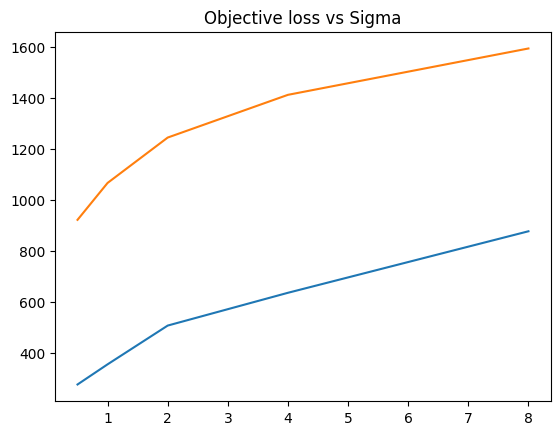

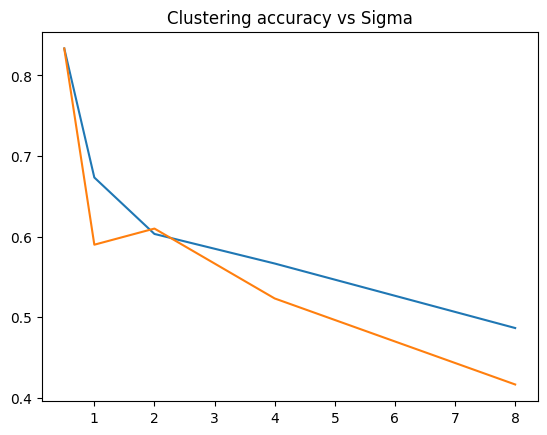

In [ ]:
# 1.2
sigmas = [0.5, 1, 2, 4, 8]
kl = []
ka = []
gl = []
ga = []
for sig in sigmas:
    km_loss, km_acc, gmm_loss, gmm_acc = generate_reports_1_2(sig)
    kl.append(km_loss)
    ka.append(km_acc)
    gl.append(gmm_loss)
    ga.append(gmm_acc)

plt.plot(sigmas, kl, label='KMeans')
plt.plot(sigmas, gl, label='GMM')
plt.title('Objective loss vs Sigma')
plt.show()

plt.plot(sigmas, ka, label='KMeans')
plt.plot(sigmas, ga, label='GMM')
plt.title('Clustering accuracy vs Sigma')
plt.show()


In [86]:

def buggy_pca(X, d):
    '''Buggy PCA'''
    _, cov, Vt = np.linalg.svd(X)
    V = Vt[:d, :].T
    Z = X @ V
    X_reconstructed = Z @ V.T
    return Z, V, cov, X_reconstructed

def demeaned_pca(X, d):
    '''Demeaned PCA'''
    mean_X = np.mean(X, axis=0)
    X_demeaned = X - mean_X
    _, cov, Vt = np.linalg.svd(X_demeaned)
    V = Vt[:d, :].T
    Z = X_demeaned @ V
    X_reconstructed = Z @ V.T + mean_X
    return Z, V, cov, X_reconstructed

def normalized_pca(X, d):
    '''Normalized PCA'''
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    X_normalized = (X - mean_X) / std_X
    _, cov, Vt = np.linalg.svd(X_normalized)
    V = Vt[:d, :].T
    Z = X_normalized @ V
    X_reconstructed = (Z @ V.T) * std_X + mean_X
    return Z, V, cov, X_reconstructed

def dro(X, d):
    '''DRO'''
    mean_X = np.mean(X, axis=0)
    Y = X - mean_X
    _, cov, Vt = np.linalg.svd(Y)
    A = Vt[:d, :].T
    Z = Y @ A
    X_reconstructed = Z @ A.T + mean_X
    return Z, A, cov, X_reconstructed

def get_reconstruction_error(X, X_reconstructed):
    return np.sum((X-X_reconstructed)**2)/len(X)

In [76]:
def read_data(filenames):
    data = []
    for fn in filenames:
        with open(fn, 'r') as file:
            d = []
            for line in file.readlines():
                d.append(list(map(float, line.split(','))))
            data.append(np.array(d))
    return data

In [77]:
ds2, ds1000 = read_data(['data2D.csv', 'data1000D.csv'])

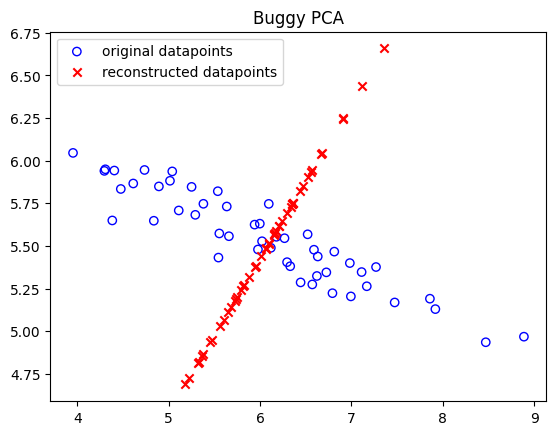

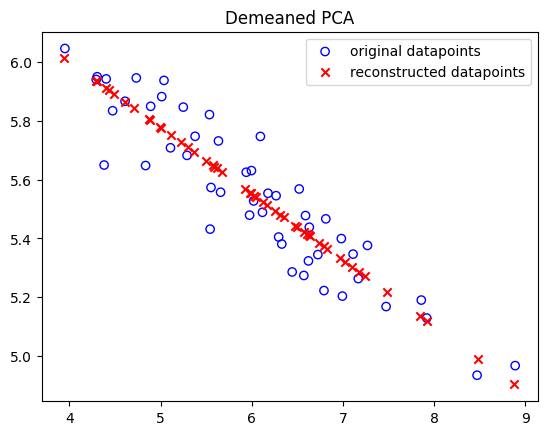

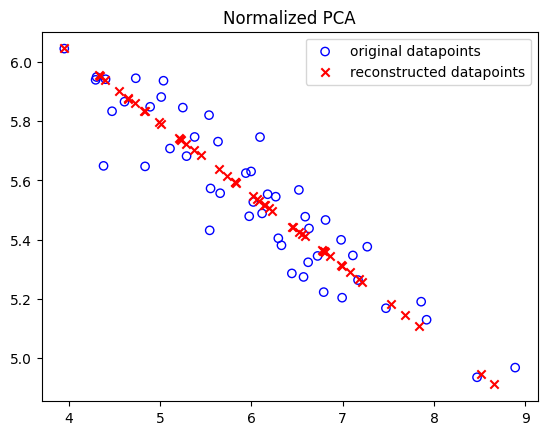

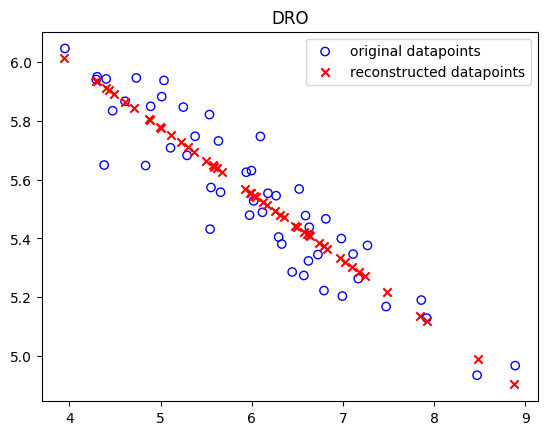


Results for 2D dataset:
| Technique      | Reconstruction error (MSE) |
|————————————————|————————————————————————————|
| Buggy PCA      | 0.8869030837347942         |
| Demeaned PCA   | 0.01000608562851292        |
| Normalized PCA | 0.04947208345477068        |
| DRO            | 0.01000608562851292        |


In [102]:
# Dataset 2D analysis and results
x1 = ds2[:,0]
x2 = ds2[:,1]
mat = [['Technique', 'Reconstruction error (MSE)']]
for dr in [buggy_pca, demeaned_pca, normalized_pca, dro]:
    results2 = dr(ds2, 1)
    r1 = results2[3][:,0]
    r2 = results2[3][:,1]
    r_err = get_reconstruction_error(ds2, results2[3])
    mat.append([dr.__doc__, r_err])

    plt.scatter(x1, x2, label='original datapoints', edgecolors='blue', facecolors='none')
    plt.scatter(r1, r2, label='reconstructed datapoints', facecolors='red', marker='x')
    plt.title(dr.__doc__)
    plt.legend()
    plt.show()
print('\nResults for 2D dataset:')
print(fmt_matrix(mat, header_row=True))

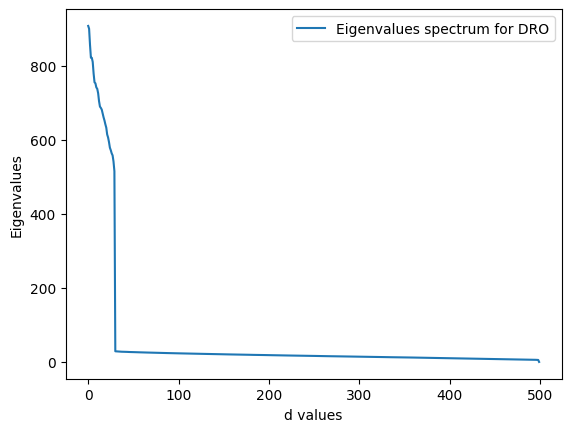


Optimal value of d for 1000D dataset: 30
Results for 1000D dataset:
| Technique      | Reconstruction error (MSE) |
|————————————————|————————————————————————————|
| Buggy PCA      | 802.7313986203585          |
| Demeaned PCA   | 273.04595897860275         |
| Normalized PCA | 273.6285809976232          |
| DRO            | 273.04595897860275         |


In [115]:
# Dataset 1000D analysis and results

def find_optimal_d(data = ds1000):
    results = dro(data, data.shape[1])
    cov = results[2]
    plt.plot(range(len(cov)), cov, label='Eigenvalues spectrum for DRO')
    plt.xlabel('d values')
    plt.ylabel('Eigenvalues')
    plt.legend()
    plt.show()
    diffs = cov[1:]-cov[:-1]
    ddiffs = diffs[1:]-diffs[:-1]
    return np.argmax(ddiffs) + 1

d_d1000 = find_optimal_d(ds1000)

mat = [['Technique', 'Reconstruction error (MSE)']]
for dr in [buggy_pca, demeaned_pca, normalized_pca, dro]:
    results1000 = dr(ds1000, d_d1000)
    r_err = get_reconstruction_error(ds1000, results1000[3])
    mat.append([dr.__doc__, r_err])

print('\nOptimal value of d for 1000D dataset:', d_d1000)
print('Results for 1000D dataset:')
print(fmt_matrix(mat, header_row=True))